In [1]:
import pickle
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
from math import sqrt

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
games = pd.read_pickle('game_data/games_four_years.pkl')
g2018 = pd.read_pickle('game_data/games_2018.pkl')

In [3]:
g2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1203 entries, 10 to 3156
Data columns (total 35 columns):
Date       1203 non-null object
W          1203 non-null int64
Ws         1203 non-null int64
Wp         1203 non-null float64
ppg        1203 non-null float64
pApg       1203 non-null float64
FGp        1203 non-null float64
3Pp        1203 non-null float64
FTp        1203 non-null float64
ORBpg      1203 non-null float64
RBpg       1203 non-null float64
ASTpg      1203 non-null float64
STLpg      1203 non-null float64
BLKpg      1203 non-null float64
TOpg       1203 non-null float64
PFpg       1203 non-null float64
Tm         1203 non-null object
sos        1203 non-null float64
matchup    1203 non-null object
ID         1203 non-null object
count      1203 non-null int64
OPppg      1203 non-null float64
OPpApg     1203 non-null float64
OPFGp      1203 non-null float64
OP3Pp      1203 non-null float64
OPFTp      1203 non-null float64
OPORBpg    1203 non-null float64
OPRBpg     

In [4]:
'''Shuffle DataFrames'''
games = games.sample(frac=1).reset_index(drop=True)
g2018 = g2018.sample(frac=1).reset_index(drop=True)

In [5]:
Xy_train = games[['W', 'Wp', 'ppg', 'pApg', 'FGp', '3Pp', 'FTp', 'ORBpg', 'RBpg', 
            'ASTpg', 'STLpg', 'BLKpg', 'TOpg', 'PFpg', 'sos', 'OPppg', 
            'OPpApg', 'OPFGp', 'OP3Pp', 'OPFTp', 'OPORBpg', 'OPRBpg', 
            'OPASTpg', 'OPSTLpg', 'OPBLKpg', 'OPTOpg', 'OPPFpg', 'OPsos']]

Xy_test = g2018[['W', 'Wp', 'ppg', 'pApg', 'FGp', '3Pp', 'FTp', 'ORBpg', 'RBpg', 
            'ASTpg', 'STLpg', 'BLKpg', 'TOpg', 'PFpg', 'sos', 'OPppg', 
            'OPpApg', 'OPFGp', 'OP3Pp', 'OPFTp', 'OPORBpg', 'OPRBpg', 
            'OPASTpg', 'OPSTLpg', 'OPBLKpg', 'OPTOpg', 'OPPFpg', 'OPsos']]

In [6]:
Xy_test['W'].value_counts() 
# pretty even on wins and losses

0    616
1    587
Name: W, dtype: int64

In [7]:
# Set up features and targets
X_train = Xy_train.iloc[:, 1:].as_matrix()
y_train = Xy_train.iloc[:, 0].as_matrix()

In [8]:
# Set up features and targets
X_test = Xy_test.iloc[:, 1:].as_matrix()
y_test = Xy_test.iloc[:, 0].as_matrix()

In [9]:
'''Standardize Data'''
scale = StandardScaler()
scale.fit(X_train)
X_train = scale.transform(X_train)
X_test = scale.transform(X_test)

In [10]:
'''Fit model on training data'''
lg = LogisticRegression()  # penalty='l2' as default which is Ridge
lg.fit(X_train, y_train)
lg_predict = lg.predict(X_test)
lg_predict_proba = lg.predict_proba(X_test)

In [11]:
lg_predict

array([1, 0, 1, ..., 1, 1, 0])

In [12]:
lg_predict_proba

array([[ 0.26973418,  0.73026582],
       [ 0.87959357,  0.12040643],
       [ 0.22715099,  0.77284901],
       ..., 
       [ 0.10756151,  0.89243849],
       [ 0.06631875,  0.93368125],
       [ 0.88690328,  0.11309672]])

In [11]:
coefficients = list(lg.coef_.ravel())
coefficients = [float(i) for i in coefficients]
features = Xy_test.columns
features = list(features[1:])

In [12]:
coefficient_df = pd.DataFrame(np.column_stack([features, coefficients]), 
                               columns=['Features', 'Coefficients'])

coefficient_df.set_index('Features')

,Coefficients
Features,
Wp,0.8938263518326638
ppg,0.4953629815028778
pApg,-0.60737590016257
FGp,0.03663209857794825
3Pp,0.16515379006799288
FTp,0.10720118318859873
ORBpg,-0.03652538257403994
RBpg,0.10620179757363848
ASTpg,-0.07712333708834859


In [13]:
# coefficient_df.Coefficients = coefficient_df.Coefficients.round(2)
    
# coefficient_df

In [14]:
lg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [15]:
lg_predict_proba

array([[ 0.07007243,  0.92992757],
       [ 0.95646736,  0.04353264],
       [ 0.6360827 ,  0.3639173 ],
       ..., 
       [ 0.43579947,  0.56420053],
       [ 0.39337127,  0.60662873],
       [ 0.12114456,  0.87885544]])

In [16]:
y_score = lg_predict_proba[:, [0]]

In [17]:
lg_accuracy = metrics.accuracy_score(y_test, lg_predict)
lg_precision = metrics.precision_score(y_test, lg_predict)
lg_recall = metrics.recall_score(y_test, lg_predict)
lg_f1 = metrics.f1_score(y_test, lg_predict)
print('Accuracy: {:.2f} (% predicted correctly)'.format(lg_accuracy))
print('Precision: {:.2f} (predicted positives % correct)'.format(lg_precision))
print('Recall: {:.2f} (% of positives predicted correctly)'.format(lg_recall))
print('f1 Score: {:.2f} (weighted average of Precision and Recall)'.format(lg_f1))

Accuracy: 0.78 (% predicted correctly)
Precision: 0.78 (predicted positives % correct)
Recall: 0.77 (% of positives predicted correctly)
f1 Score: 0.78 (weighted average of Precision and Recall)


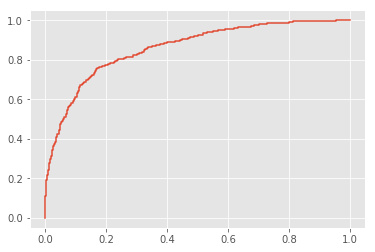

In [18]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_score)
roc_auc = metrics.roc_auc_score(y_test, y_score)
plt.plot(tpr, fpr, label= 'AUC= {:.2f}'.format(roc_auc));

In [19]:
metrics.roc_auc_score(y_test, y_score)

0.13960762406247926

In [20]:
np.isnan(y_train)[np.isnan(y_train) == False].size

4886

In [21]:
'''Fit model on training data'''
lasso = LogisticRegression(penalty='l1')
lasso.fit(X_train, y_train)
lasso_predict = lg.predict(X_test)
lasso_predict_proba = lg.predict_proba(X_test)

In [22]:
lasso_accuracy = metrics.accuracy_score(y_test, lasso_predict)
lasso_precision = metrics.precision_score(y_test, lasso_predict)
lasso_recall = metrics.recall_score(y_test, lasso_predict)
lasso_f1 = metrics.f1_score(y_test, lasso_predict)
print('Accuracy: {:.2f} (% predicted correctly)'.format(lasso_accuracy))
print('Precision: {:.2f} (predicted positives % correct)'.format(lasso_precision))
print('Recall: {:.2f} (% of positives predicted correctly)'.format(lasso_recall))
print('f1 Score: {:.2f} (weighted average of Precision and Recall)'.format(lasso_f1))

Accuracy: 0.78 (% predicted correctly)
Precision: 0.78 (predicted positives % correct)
Recall: 0.77 (% of positives predicted correctly)
f1 Score: 0.78 (weighted average of Precision and Recall)


## Cross Validation

In [23]:
logcv = LogisticRegression()
lassocv = LogisticRegression(penalty='l1')
log_cv_acc = cross_validate(logcv, X_train, y_train, scoring='accuracy', cv=5, return_train_score=False)
lasso_cv_acc = cross_validate(lassocv, X_train, y_train, scoring='accuracy', cv=5, return_train_score=False)
print('Logistic Regression (Ridge) Accuracy: {:.2f}'.format(log_cv_acc['test_score'].mean()))
print('Logistic Regression (Lasso) Accuracy: {:.2f}'.format(lasso_cv_acc['test_score'].mean()))

Logistic Regression (Ridge) Accuracy: 0.79
Logistic Regression (Lasso) Accuracy: 0.79


Cross Validation improves score by .01 or 1%

## Optimize Cs!!! Can't figure out

In [35]:
Cs = list(np.linspace(0.1, 3, 100))
accs = []
for c in Cs:
    lgc = LogisticRegression(C=c)
    lgc.fit(X_train, y_train)
    lgc_acc = metrics.accuracy_score(y_test, lg_predict)
    accs.append(lgc_acc) 

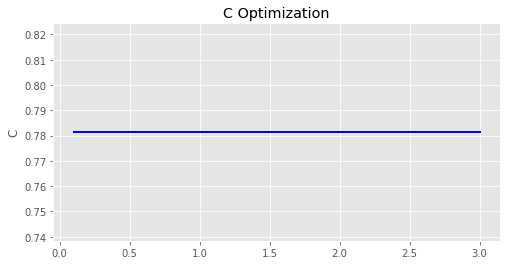

In [36]:
## initialize the axes
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)

## format axes
ax.set_ylabel('C')
ax.set_title('C Optimization')

line, = ax.plot(Cs, accs, color='blue', lw=2)

In [37]:
'''sklearn.model_selection.cross_val_score(estimator, X, y=None, groups=None, scoring=None, cv=None, 
n_jobs=1, verbose=0, fit_params=None, pre_dispatch=‘2*n_jobs’)

class sklearn.model_selection.GridSearchCV(estimator, param_grid, scoring=None, fit_params=None, 
n_jobs=1, iid=True, refit=True, cv=None, verbose=0, pre_dispatch=‘2*n_jobs’, error_score=’raise’, 
return_train_score=’warn’)
'''
grid_search_results = GridSearchCV(lg, param_grid={'C':Cs}, scoring='accuracy', cv=5)
           
grid_search_results.fit(X_train, y_train)

grid_search_results.best_params_

{'C': 0.94949494949494939}

In [26]:
# logregrescv = LogisticRegressionCV(Cs=10, fit_intercept=True, cv=5, dual=False, penalty=’l2’, scoring=None)